In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

---
## 모델 준비
이미지를 분할을 위해 `deeplabv3` 모델을 다운로드받고 준비합니다

```py
model_dir = './models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
urllib.request.urlretrieve(model_url, model_file)
```

In [2]:
model_file = './models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

---
## 이미지 준비

(1825, 2738, 3)


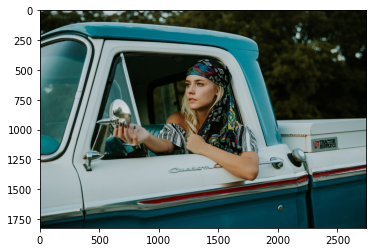

In [3]:
img_path = './data/car.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

---
## image segmentation
`segmentAsPascalvoc()`를 사용하여 분할할 이미지 영역을 구합니다.

- seg values에는 `class_ids`와 `masks`가 저장됩니다.`class_ids`를 통해 어떤 물체가 담겨 있는지 알 수 있습니다.

- output에는 분할하려는 이미지에서의 mask위치가 저장됩니다.

In [4]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [5]:
segvalues

{'class_ids': array([ 0,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

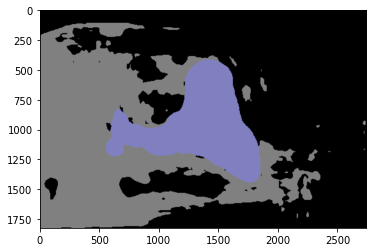

In [6]:
#분할된 이미지 결과
plt.imshow(output)
plt.show()

 ```py
 LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
 ```

PixelLib에서는 아래와 같이 객체와 색상을 매핑하였습니다.

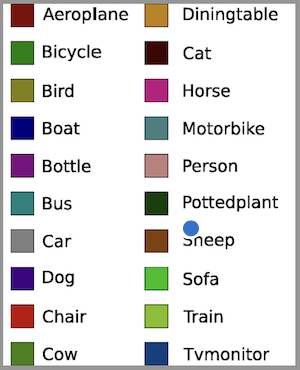

In [7]:
# PixelLib에서 그대로 가져온 코드입니다
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [8]:
colormap[15] #사람:15, 고양이:8

array([192, 128, 128])

In [9]:
seg_color = (128,128,192) #bgr을 rgb로 변환

(1825, 2738)


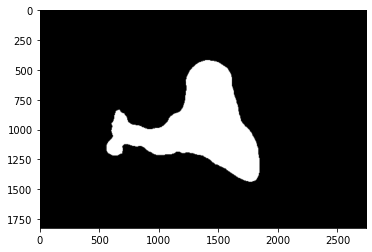

In [10]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

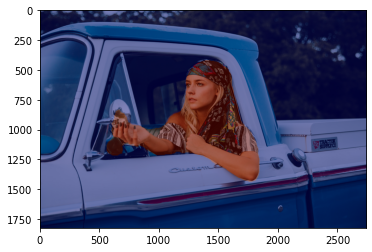

In [11]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### cv2.blur(input_img, mask_size)
`blur()`을 사용하여 이미지를 흐리게 처리할 수 있습니다.
- `input_img`를 통해 입력할 이미지를 지정해줍니다.
- `mask_size`를 통해 흐림의 정도를 정해줄 수 있습니다.

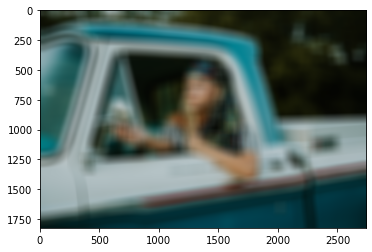

In [12]:
img_orig_blur = cv2.blur(img_orig, (100,100))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

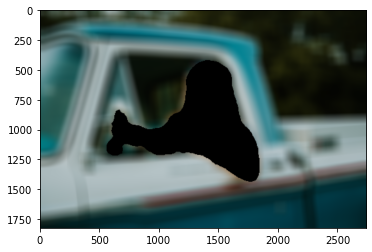

In [13]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### np.where(조건, True, False)

조건식에 만족하는 pixel은 True값으로 치환, 조건을 만족하지 못하는 pixel은 False에 기입된 값으로 치환하는 함수입니다.<br>
where()를 사용하여 마스킹 이미지와 원본 이미지를 합성해줍니다.

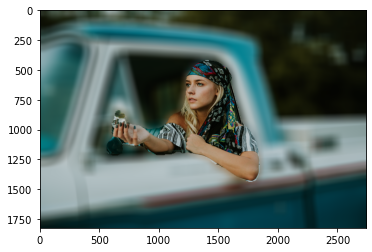

In [14]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

---
## 함수로 만들기
위의 과정을 하나의 함수로 만들어 여러 이미지에 쉽게 적용할 수 있습니다.

```py
    def segmentated_blur(img_path, index, blur_size)
```
- img_path: 입력할 이미지의 경로
- index: 분할할 객체의 index정보
- blur_size: 흐림의 정도를 지정해줄 mask크기

In [15]:
def segmentated_blur(img_path, index, blur_size):
    img_orig = cv2.imread(img_path) 
    model = semantic_segmentation()
    model.load_pascalvoc_model(model_file)

    segvalues, output = model.segmentAsPascalvoc(img_path)
    
    colormap = np.zeros((256, 3), dtype = int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3
        
    colormap=list(colormap[index])
    seg_color = (colormap[2],colormap[1],colormap[0]) #bgr => rgb
    
    seg_map = np.all(output==seg_color, axis=-1)
    
    img_mask = seg_map.astype(np.uint8) * 255
    
    img_orig_blur = cv2.blur(img_orig, (blur_size,blur_size))
    
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)),plt.title('Original',fontsize=20)
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)),plt.title('Segmentated Blur',fontsize=20)
    plt.show()
    
    #return img_concat

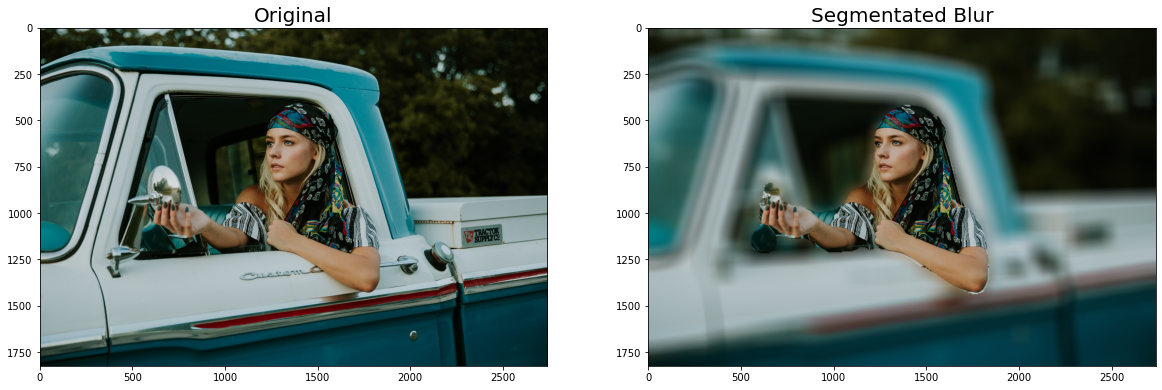

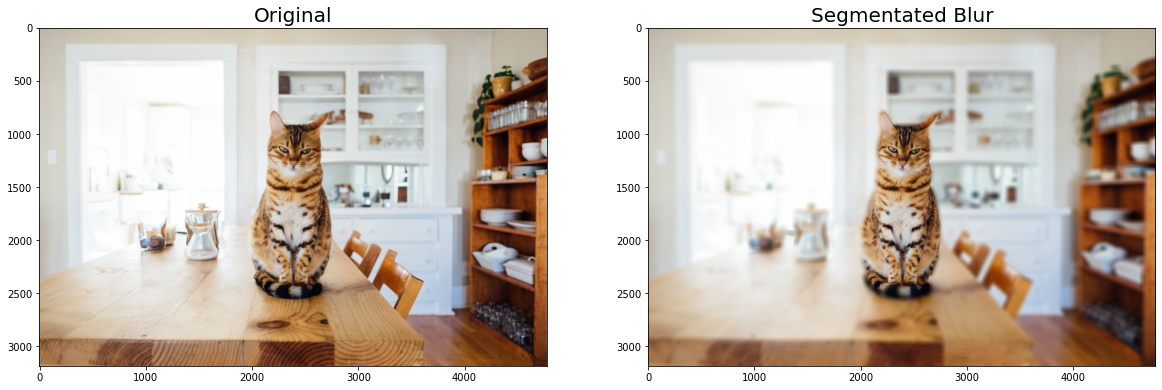

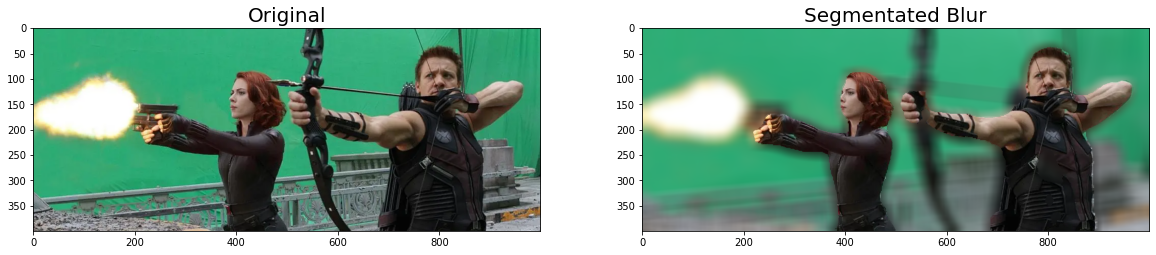

In [16]:
img_path1 = './data/car.png'  
img_path2 = './data/cat.png'  
img_path3 = './data/chromakey.png'  

segmentated_blur(img_path1, 15, 100)
segmentated_blur(img_path2, 8, 50)
segmentated_blur(img_path3, 15, 30)

---
## 문제점
아래의 사진에서와 같이 경계선이 불분명하게 나타나는 문제점이 있습니다.


## 해결 방안


---
# 회고
deeplabv3라는 이미 학습된 모델을 가져와 편리하게 이미지 분할을 할 수 있었습니다. 또한 전체적인 과정을 함수로 나타내어 나중에 다시 사용할 경우가 생긴다면 간편하게 사용할 수 있을 것 같습니다.


2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.
인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.

3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.
추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.
